## Backtesting Trading Signals

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs
import datetime
import matplotlib.pyplot as plt
# Yahoo Finance Dataset
today = datetime.datetime.now().strftime("%Y-%m-%d")
spx = yf.download('^GSPC', start='2014-01-01', end=today)
close_prices = spx['Close']

[*********************100%***********************]  1 of 1 completed


Moving Average Indicator: We can get short and long term average prices over time (50 days and 1 year). We can then generate a buy signal when the short-term moving average crosses above the long-term moving average and a sell signal when it crosses below.

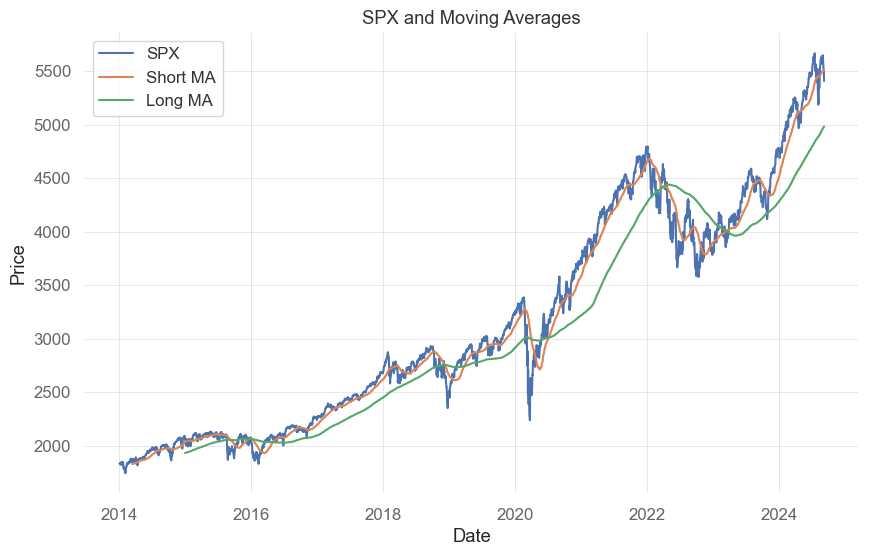

In [3]:
# Calculating Moving Averages (Indicators)
short_window = 50
long_window = 252
short_ma = close_prices.rolling(window=short_window, min_periods=short_window).mean()
long_ma = close_prices.rolling(window=long_window, min_periods=long_window).mean()
#Plotting the Moving Averages
plt.figure(figsize=(10, 6))
plt.plot(spx.index, spx['Close'], label='SPX')
plt.plot(short_ma.index, short_ma, label='Short MA')
plt.plot(long_ma.index, long_ma, label='Long MA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SPX and Moving Averages')
plt.legend()
plt.show()

Indicators primarily describe current or past market conditions, signals provide actionable insights for future trades. 

Signals usually range from -1 to 1, representing the confidence level of a prediction. Negative values are bearish, Positive are bullish, values around 0 are neutral. 

The closer a signal is to the extremities, the higher the confidence in the forecast. While signals guide the direction of the trade (long or short), they don't dictate the position size or the risk management strategy. The strength of the signal should be used in conjunction with other factors, such as portfolio balance, risk tolerance, and market conditions, to make informed trading decisions.

Let's begin with a simple buy or sell signal for when moving averages cross paths.

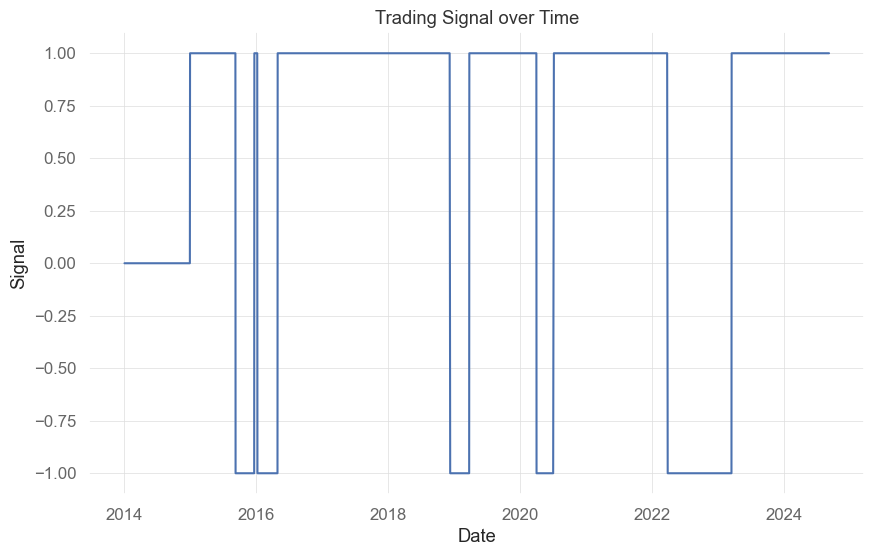

In [4]:
# Generating Trading Signals
signals = pd.DataFrame(index=close_prices.index)
signals['signal'] = 0.0  # Set the default to be 0
signals['short_ma'] = short_ma
signals['long_ma'] = long_ma

# 1 = long, -1 = short
signals.loc[signals['short_ma'] > signals['long_ma'], 'signal'] = 1
signals.loc[signals['short_ma'] < signals['long_ma'], 'signal'] = -1
plt.figure(figsize=(10, 6))
plt.plot(signals.index, signals['signal'])
plt.xlabel('Date')
plt.ylabel('Signal')
plt.title('Trading Signal over Time')
plt.show()

### Computing Strategy Returns
Proper calculation of returns is essential for evaluating the performance of any trading strategy. 

Addressing Look-Ahead Bias: This occurs when a strategy uses information that would not have been available at the time of trading. To avoid this, we lag our signals by one day. This adjustment ensures that our strategy only uses information that would have been available at the market close of the previous day.

First, we compute the daily returns of the S&P 500. Next, we apply our trading signals to these returns. The signal is shifted by one day to avoid look-ahead bias.

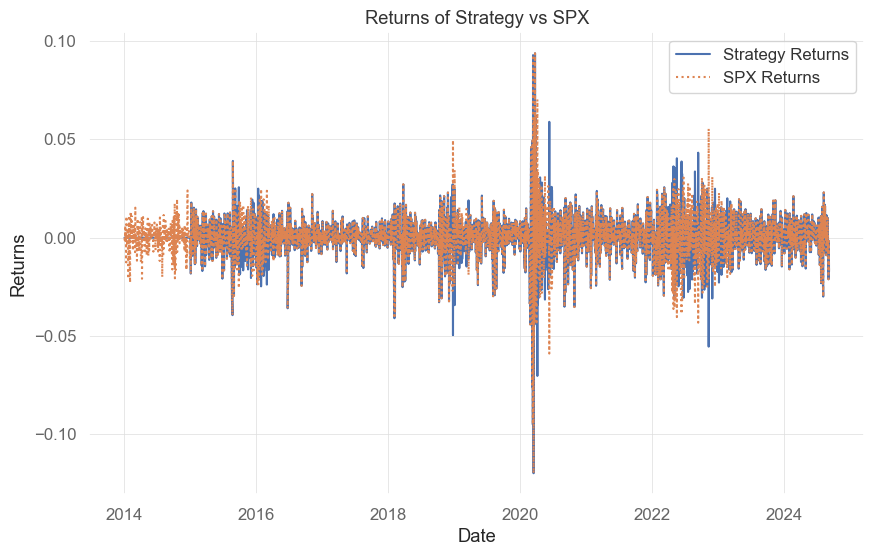

In [5]:
# Calculate daily percentage returns of SPX
spx_returns = close_prices.pct_change()
# Calculate strategy returns by multiplying SPX returns with the lagged signals
strategy_returns = spx_returns * signals['signal'].shift(1)

plt.figure(figsize=(10, 6))
plt.plot(strategy_returns.index, strategy_returns, label='Strategy Returns')
plt.plot(spx_returns.index, spx_returns, linestyle='dotted', label='SPX Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns of Strategy vs SPX')
plt.legend()
plt.show()

### Position Sizing
Position sizing is a critical aspect of trading strategy that can significantly impact the risk and return profile of an investment portfolio. It involves determining the appropriate amount of capital to allocate to each investment, balancing risk and potential returns. (Kelly Criterion)

Mean-Variance Portfolio Construction: This foundational concept in modern portfolio theory helps in optimizing the allocation of weights to different assets, based on their expected returns, risks (variance), and correlations.

Meta-Labeling: An advanced technique that integrates machine learning. Meta-labeling not only decides the direction of trades (long or short) but also helps in determining the size of positions, based on the probability of a successful prediction.

For a single asset we can use volatility targeting. Volatility-targeted position sizing helps in standardizing risk across different positions, aligning each trade with the overall risk tolerance of the portfolio. This approach dynamically adjusts position sizes based on changing market volatility, contributing to more effective risk management. By clipping the maximum weight to 1, the strategy avoids the use of leverage, sticking to a more conservative investment approach.

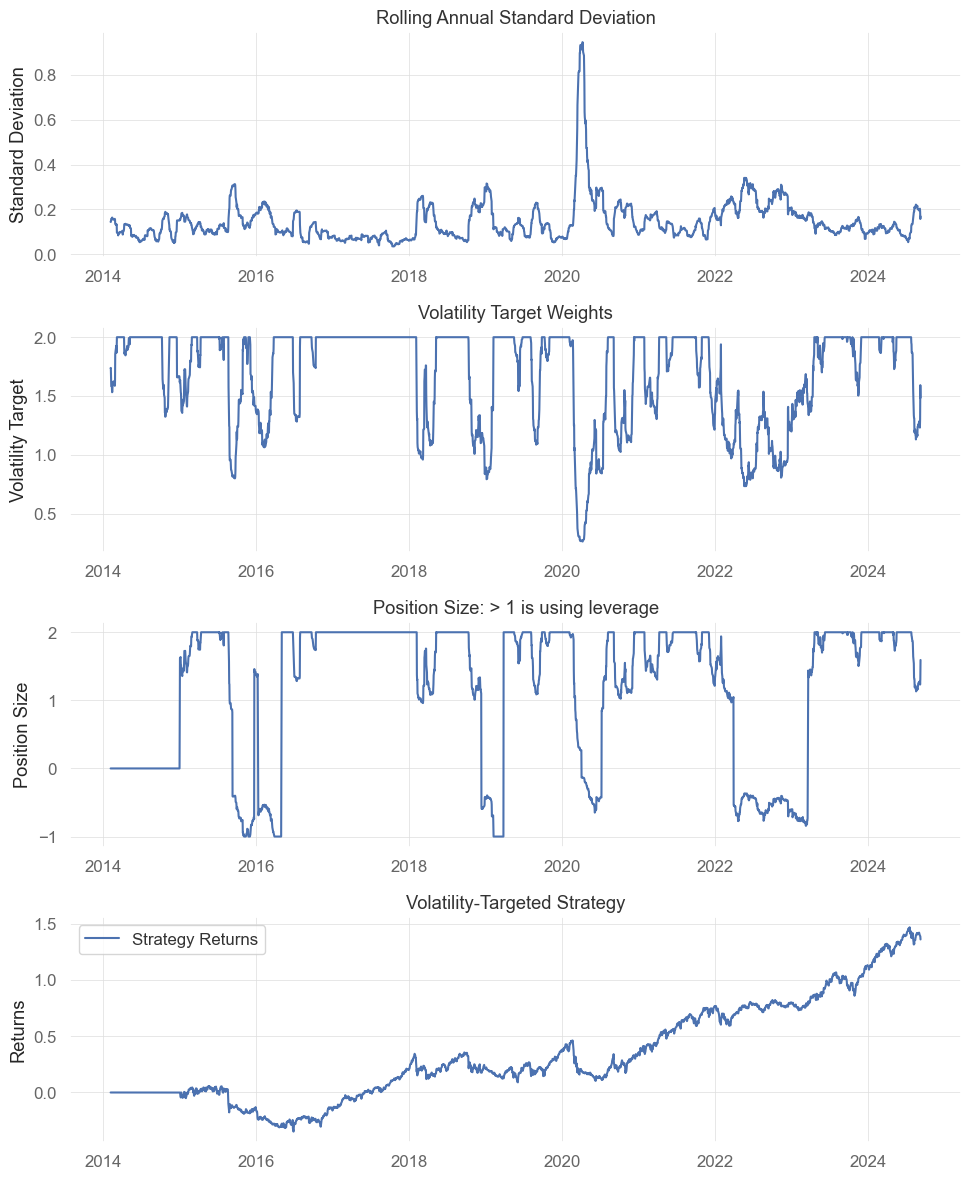

In [6]:
# Set the target volatility level
tgt_vol = 0.25
# Calculate the rolling annual standard deviation of SPX returns
# Convert to annualized standard deviation
signals['stdev'] = spx_returns.rolling(22).std() * np.sqrt(252)
# formula = target_vol / stdev
# signals are decimal values, numbers must be positive
signals['vol_tgt'] = tgt_vol / signals['stdev']
# max 2x leverage
signals['vol_tgt'] = signals['vol_tgt'].clip(0, 2)
# Adjust the signal by the volatility target, lagging both to avoid look-ahead bias
vol_signal = signals['signal'].shift(1) * signals['vol_tgt'].shift(1)
# remove leverage from short positions
vol_signal[vol_signal < 0] = vol_signal[vol_signal < 0] / 2
# Compute returns for the volatility-targeted strategy
strategy_voltgt_returns = spx_returns * vol_signal

# Create subplots
cumulative_returns = strategy_voltgt_returns.cumsum()
fig, axs = plt.subplots(4, 1, figsize=(10, 12))
# Plot the rolling annual standard deviation
axs[0].plot(signals['stdev'])
axs[0].set_title('Rolling Annual Standard Deviation')
axs[0].set_ylabel('Standard Deviation')
# Plot the volatility target weights
axs[1].plot(signals['vol_tgt'])
axs[1].set_title('Volatility Target Weights')
axs[1].set_ylabel('Volatility Target')
# Plot the position sizes to see how much leverage is being used
axs[2].plot(vol_signal)
axs[2].set_title('Position Size: > 1 is using leverage')
axs[2].set_ylabel('Position Size')
# Plot the returns for the volatility-targeted strategy
axs[3].plot(cumulative_returns, label='Strategy Returns')
axs[3].set_title('Volatility-Targeted Strategy')
axs[3].set_ylabel('Returns')
axs[3].legend()
# Adjust layout
plt.tight_layout()
plt.show()

Quantstats report

In [7]:
#Quantstats
#returns - represents the returns of our strategy that applies volatility-targeted weights.
#benchmark - the returns of our basic strategy without volatility adjustments.
#output - specifies the output format of the report - generated as an HTML file.
# Generate a small Quantstats report
qs.reports.metrics(returns=strategy_voltgt_returns, 
                benchmark=strategy_returns,
                output='small_report.html', 
                title='Volatility Targeted Strategy vs. Basic Strategy')

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2014-02-05   2014-02-05
End Period          2024-09-06   2024-09-06
Risk-Free Rate      0.0%         0.0%
Time in Market      92.0%        92.0%

Cumulative Return   34.52%       213.0%
CAGR﹪              1.95%        7.72%

Sharpe              0.25         0.63
Prob. Sharpe Ratio  79.01%       97.89%
Sortino             0.34         0.87
Sortino/√2          0.24         0.61
Omega               1.12         1.12

Max Drawdown        -45.53%      -34.91%
Longest DD Days     1659         867

Gain/Pain Ratio     0.05         0.12
Gain/Pain (1M)      0.25         0.63

Payoff Ratio        0.92         0.98
Profit Factor       1.05         1.12
Common Sense Ratio  0.95         1.12
CPC Index           0.52         0.59
Tail Ratio          0.91         1.0
Outlier Win Ratio   4.56         3.42
Outlier Loss Ratio  4.76         3.81

MTD                 -4.25%       -5.95%
3M            

c:\Users\Evan\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


Added Costs (slippage unnaccounted for)

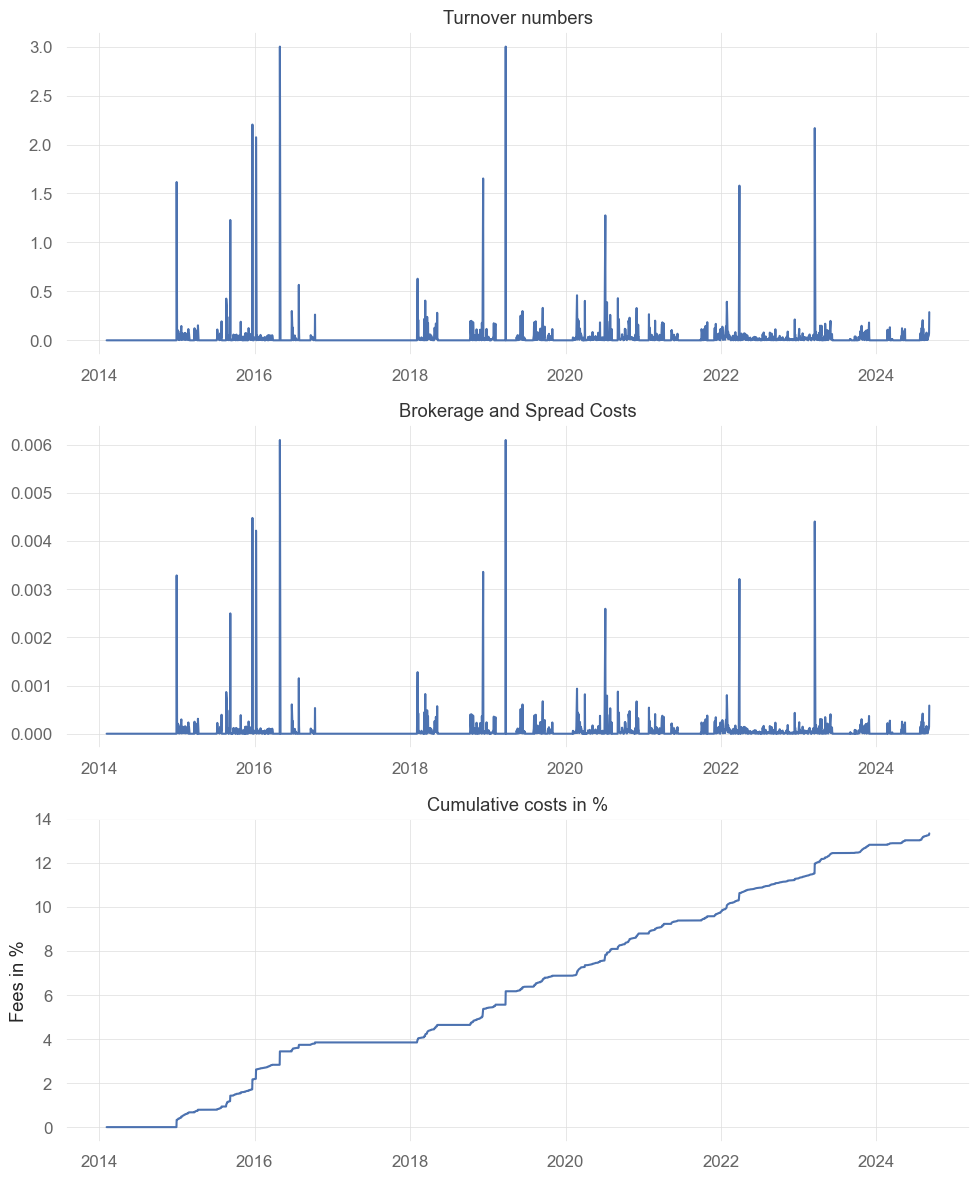

In [23]:
turnover = abs(vol_signal.diff())
# Shift by -1 to get the date at which the transaction occurred, which was at close yesterday.
turnover = turnover.shift(-1)
# Compute brokerage fees
brokerage_fees = 0.0020  # 20 basis points
brokerage = turnover * brokerage_fees
# Compute Spread fee
bid_ask_fee = 0.000032  # 0.32 basis points
spread = turnover * bid_ask_fee
total_costs = brokerage + spread

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
# Plot Turnover
axs[0].plot(turnover)
axs[0].set_title('Turnover numbers')
# Plot Brokerage
axs[1].plot(total_costs)
axs[1].set_title('Brokerage and Spread Costs')
# Plot Cum Brokerage
axs[2].plot(total_costs.cumsum() * 100)
axs[2].set_title('Cumulative costs in %')
axs[2].set_ylabel('Fees in %')
# Adjust layout
plt.tight_layout()
plt.show()

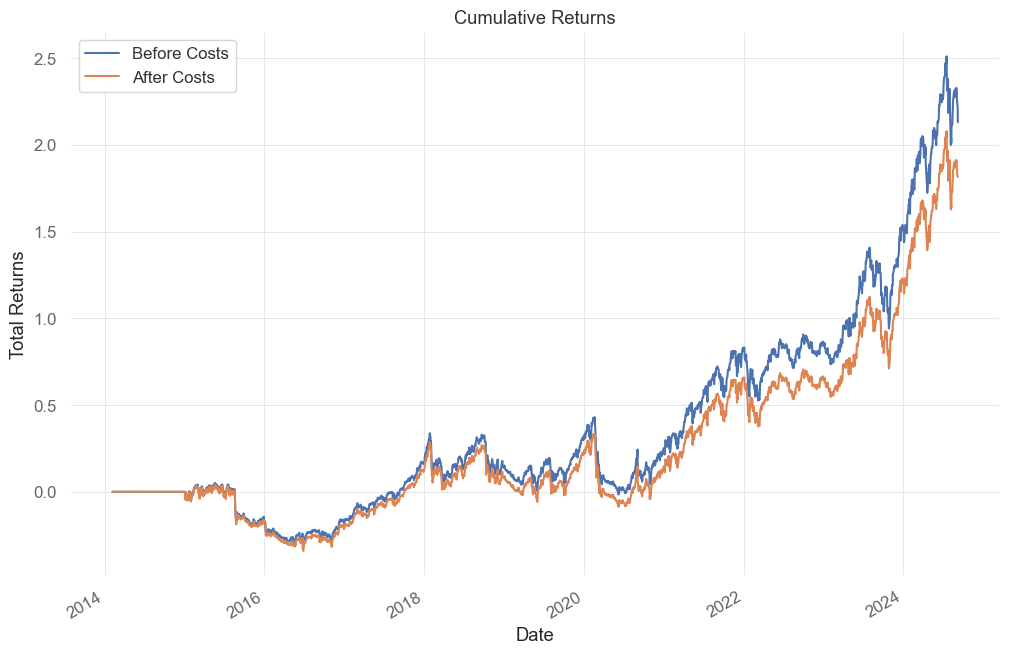

In [24]:
# Plot the cumulative rets (compounded growth)
# Before costs
((strategy_voltgt_returns + 1).cumprod()-1).plot()

# After Costs
after_cost = strategy_voltgt_returns - total_costs 
((after_cost + 1).cumprod()-1).plot(figsize = (12, 8))

# Plot Cum returns
plt.title('Cumulative Returns')
plt.legend(['Before Costs', 'After Costs'])
plt.ylabel('Total Returns')
plt.show()